In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import output_processing as op
from functools import reduce
import prompts

/Users/ab-purushothama-macbook/.conda/envs/prej-prompt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
models= [
   "meta-llama/Llama-3.2-1B",
    "meta-llama/Llama-3.2-1B-Instruct",
    "meta-llama/Llama-3.2-3B",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.1-8B",
    "meta-llama/Llama-3.1-8B-Instruct",
    # "gpt2-medium",
    "gpt2-large",
    # "gpt2-xl",
    # "allenai/OLMo-2-0425-1B",
    # "allenai/OLMo-2-0425-1B-Instruct",
    # "allenai/OLMo-2-1124-7B",
    # "allenai/OLMo-2-1124-7B-Instruct",
    # "ministral/Ministral-3b-instruct",
    # "ministral/Ministral-4b-instruct",
    "mistralai/Ministral-8B-Instruct-2410",
    # "google/gemma-3-1b-it",
    # "google/gemma-3-4b-it",
    # "google/gemma-7b-it"
]
def read_and_organize_model_results(model_name):
    model_results = pd.read_csv(f"runs/runs-1001-05_19/{model_name}-results.csv")
    model_results.replace([0.0], -65504, inplace=True)
    model_results = op.organize_distribution(model_results)
    model_results["model_name"] = model_name.split("/")[-1]
    return model_results
    
combined_results = [read_and_organize_model_results(model_name) for model_name in models]
combined_df = pd.concat(combined_results).reset_index()
combined_df.shape

(9936, 21)

# Analysis with Answer Choice

In [3]:
np.sum(combined_df["Aff_prob"] > combined_df["UnAff_prob"])/combined_df.shape[0]

np.float64(0.5341183574879227)

In [4]:
combined_df.sample()

,index,title,prompt_type,prompt,version,output,output_text,cum_logprob,Yes_probs,No_probs,...,B_probs,Other_prob,Aff_prob,UnAff_prob,Covered_prob,NotCovered_prob,Covered,NotCovered,entropy,model_name
7639,187,House Removal II,no_or_yes,"Harper's insurance covers damage from ""House R...",unambiguous_covered,"No,","No, even though she did not specifically ask ...",NaN,0.254095,0.2387,...,0.000353,0.507205,0.254095,0.2387,0.51562,0.48438,True,False,1.034383,gpt2-large


In [5]:
combined_df.groupby(['prompt_type'], as_index=False, sort=False).apply(lambda x: x.Covered.sum()) 

/var/folders/9g/y4xr1pr156905g16w5kjh4qh0000gn/T/ipykernel_12041/3110038544.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df.groupby(['prompt_type'], as_index=False, sort=False).apply(lambda x: x.Covered.sum())


,prompt_type,None
0,yes_or_no,678
1,no_or_yes,369
2,negation,330
3,agreement,910
4,agreement_negation,778
5,disagreement,413
6,disagreement_negation,358
7,options,559
8,options_flipped,912


In [6]:
combined_df.sample().Covered

6630    True
Name: Covered, dtype: bool

# Percentage answer as 'Covered'

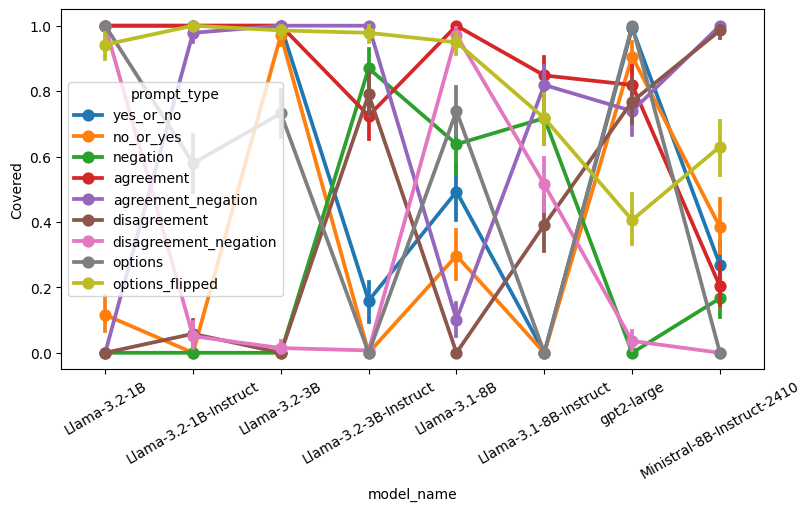

In [7]:
VAGUE_CONTRACTS_SIZE=138
fig, ax = plt.subplots(1,1, figsize=(8,5), layout='constrained')
plt.xticks(rotation=30)
point_plot = sns.pointplot(
    data = combined_df,
    x='model_name',
    y='Covered',
    hue='prompt_type',
)
# fig = point_plot.get_figure()
# fig.savefig("fig-covered-count-models.pdf", format="pdf")

## Answer 'covered' by prompt type

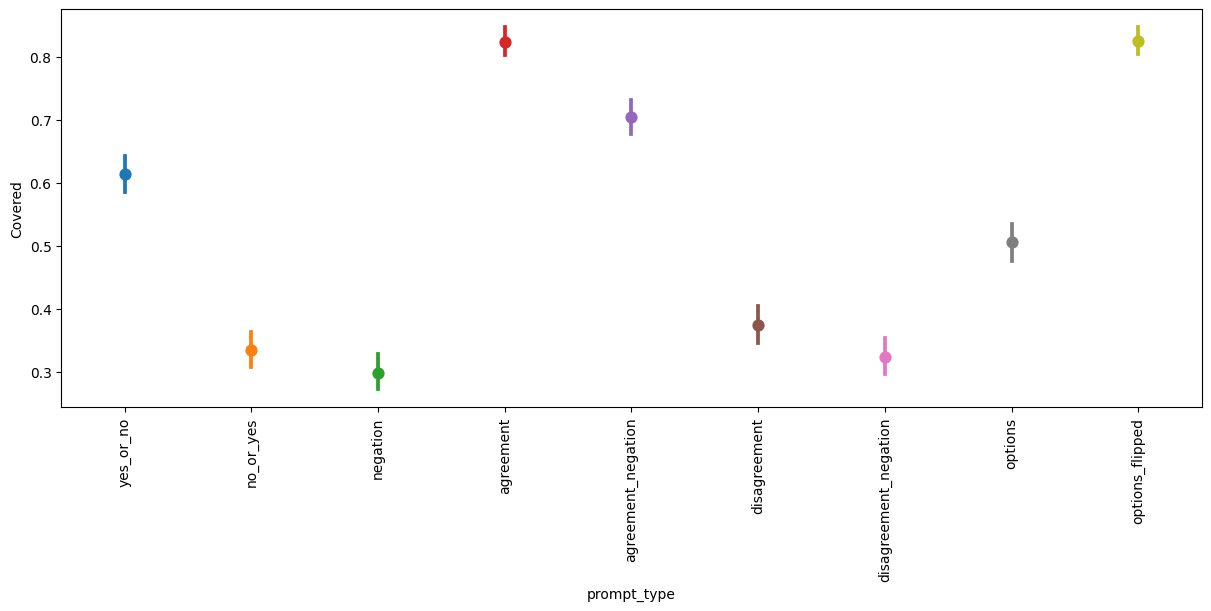

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = combined_df,
    x='prompt_type',
    y='Covered',
    hue='prompt_type',
    linestyle="None"
)
# fig = point_plot.get_figure()
# fig.savefig("fig-covered-by-model-and-prompts.pdf", format="pdf")

## 'Covered' by item (totally on all models) [Not very useful]

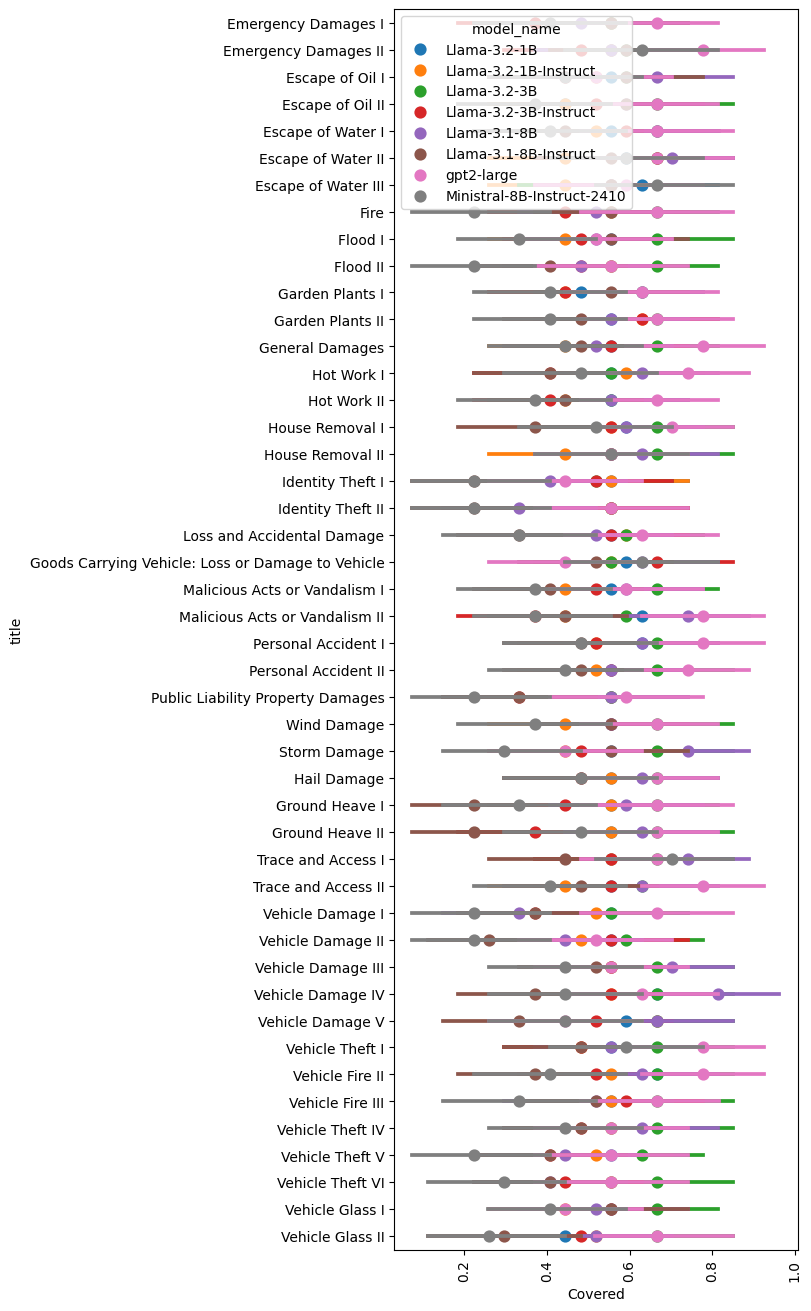

In [13]:
fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = combined_df,
    x='Covered',
    y='title',
    hue='model_name',
    linestyle="None",
    # dodge=.8 - .8 / 8
)

## Covered by item (two models only) [Just a bit more useful]

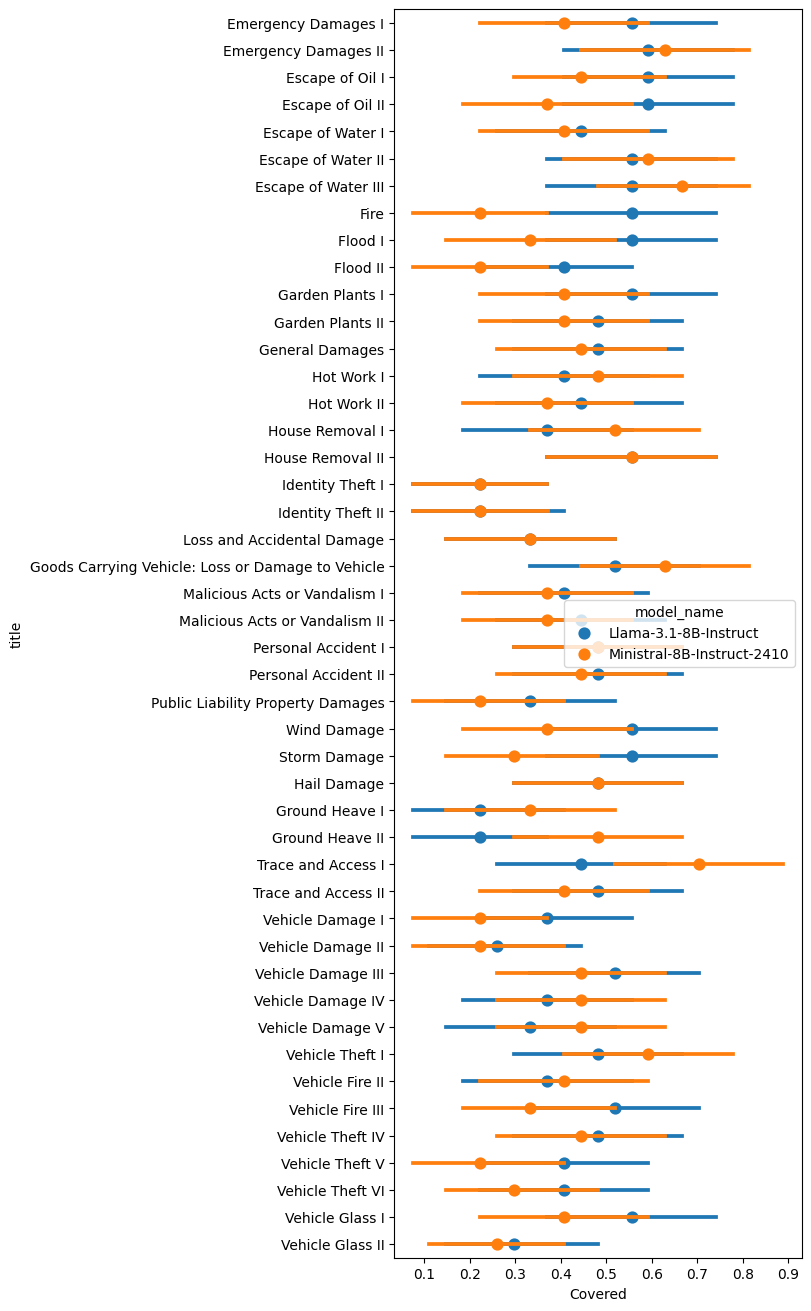

In [14]:
selected_models = ["Ministral-8B-Instruct-2410", "Llama-3.1-8B-Instruct"]
selected_df = combined_df[combined_df["model_name"].isin(selected_models)]

fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
point_plot = sns.pointplot(
    data = selected_df,
    x='Covered',
    y='title',
    hue='model_name',
    linestyle="None",
)

# Analysis with relative measures

In [15]:
relative_measures = op.calculate_relative_measures(combined_df)
relative_measures.js_dist.unique()

array([0.05296124, 0.08719652, 0.34957016, ..., 0.04590675, 0.33515636,
       0.23093642])

# Jennsen Shannon Distance

## Model wise distances by prompt type

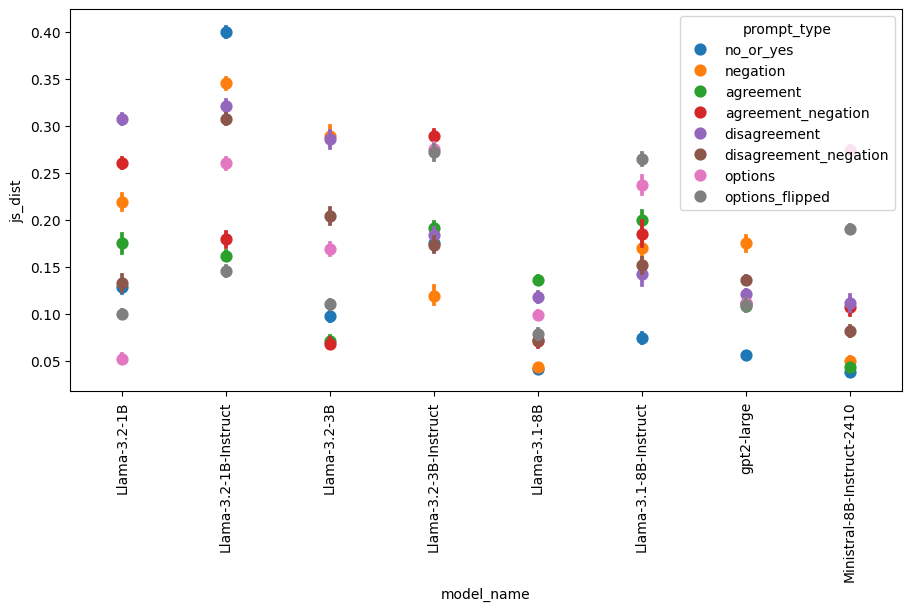

In [23]:
fig, ax = plt.subplots(1,1, figsize=(9,6), layout='constrained')
plt.xticks(rotation=90)
dist_plot_for_models = sns.pointplot(
    data=relative_measures, x='model_name', y ='js_dist', hue='prompt_type', linestyle='None')

## Distance variance by prompt type

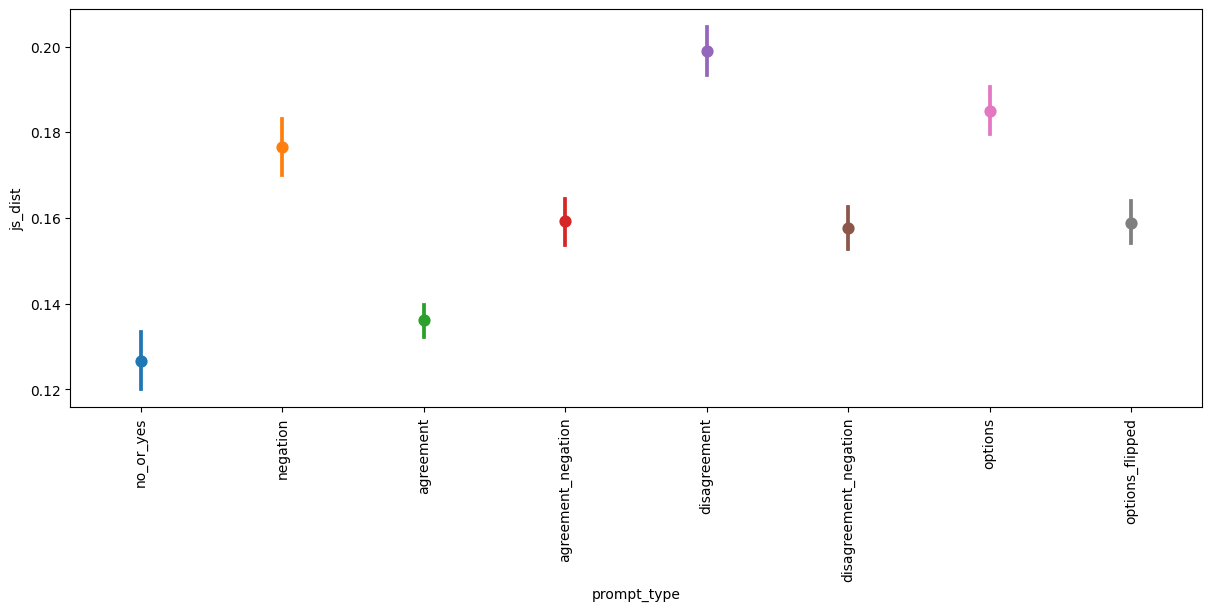

In [27]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = relative_measures,
    x='prompt_type',
    y='js_dist',
    hue='prompt_type',
    linestyle="None"
)
# fig = point_plot.get_figure()

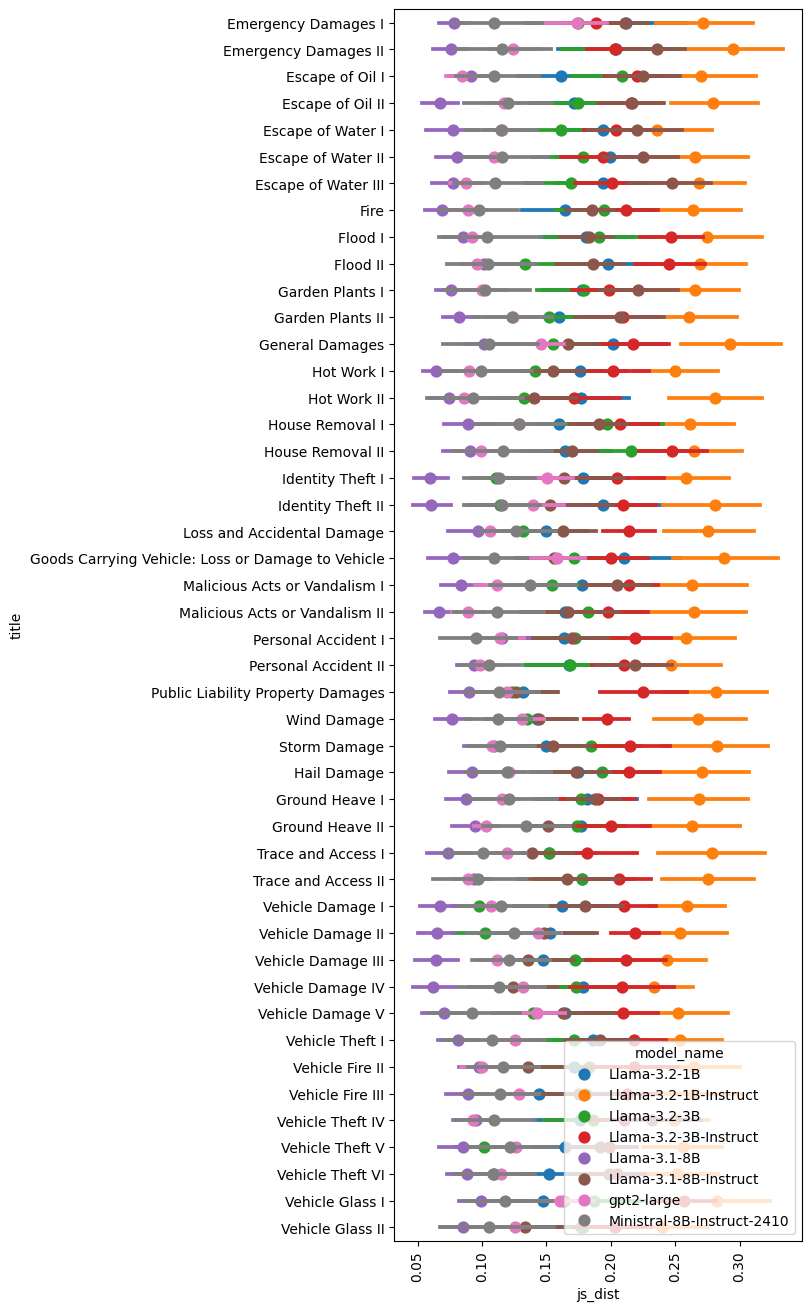

In [29]:
fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = relative_measures,
    x='js_dist',
    y='title',
    hue='model_name',
    linestyle="None",
    # dodge=.8 - .8 / 8
)

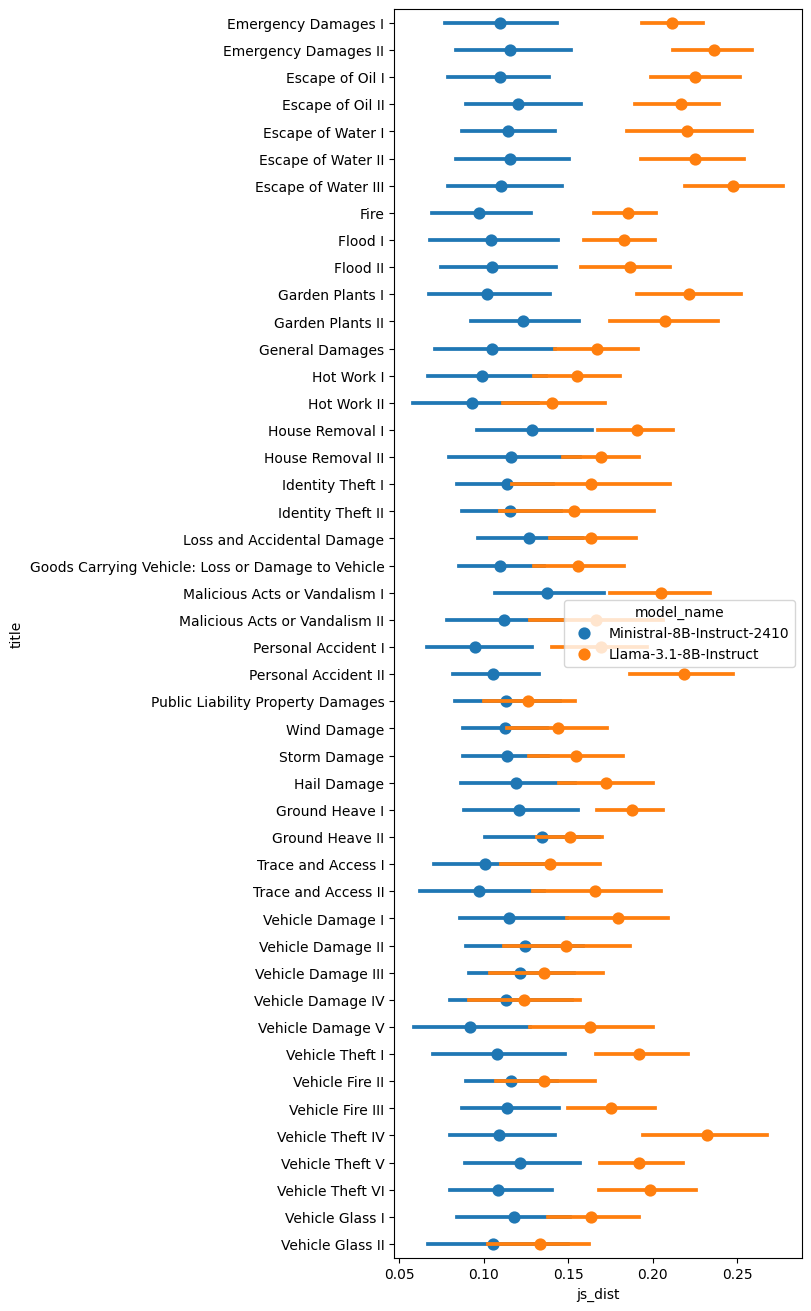

In [39]:
selected_models = ["Ministral-8B-Instruct-2410", "Llama-3.1-8B-Instruct"]
selected_df = relative_measures[relative_measures["model_name"].isin(selected_models)]

fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
point_plot = sns.pointplot(
    data = selected_df,
    x='js_dist',
    y='title',
    hue='model_name',
     hue_order=selected_models,
    linestyle="None",
)

# Conditional Entropy

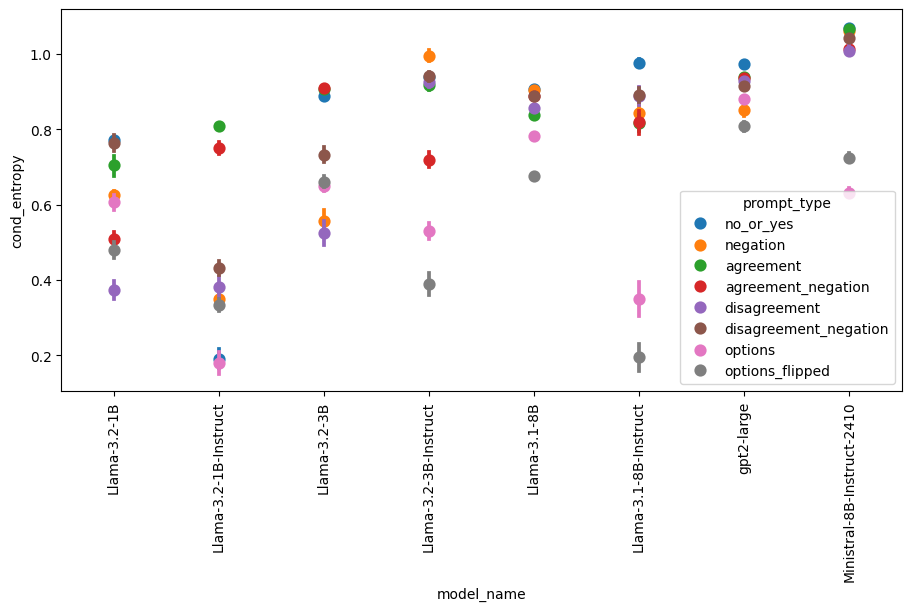

In [33]:
fig, ax = plt.subplots(1,1, figsize=(9,6), layout='constrained')
plt.xticks(rotation=90)
dist_plot_for_models = sns.pointplot(
    data=relative_measures, x='model_name', y ='cond_entropy', hue='prompt_type', linestyle='None')

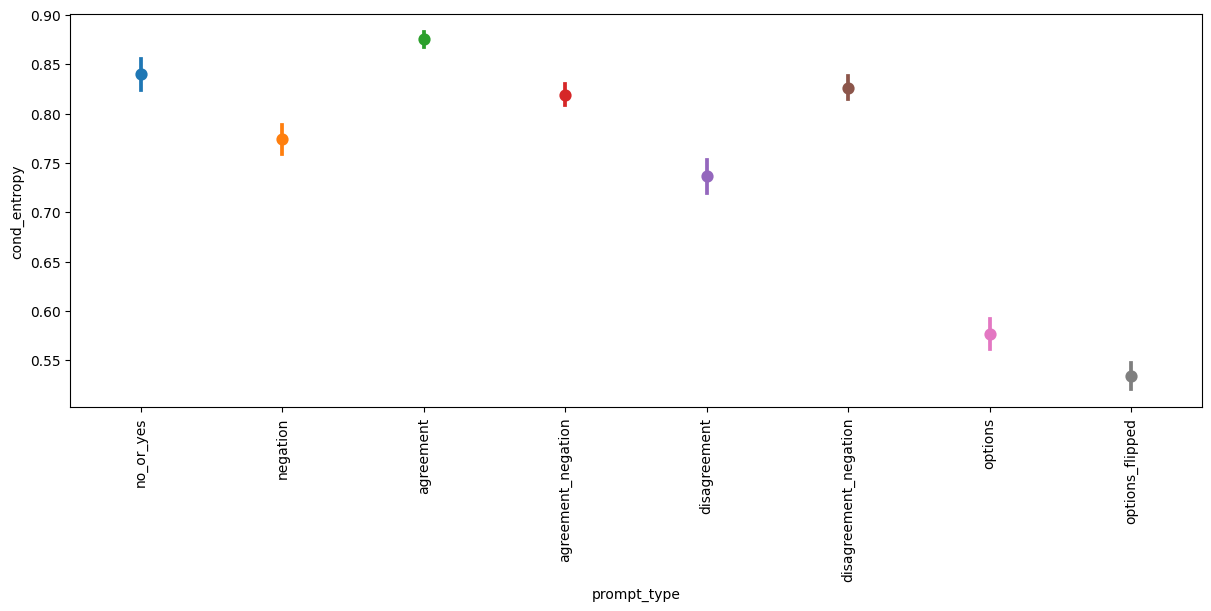

In [34]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = relative_measures,
    x='prompt_type',
    y='cond_entropy',
    hue='prompt_type',
    linestyle="None"
)
# fig = point_plot.get_figure()

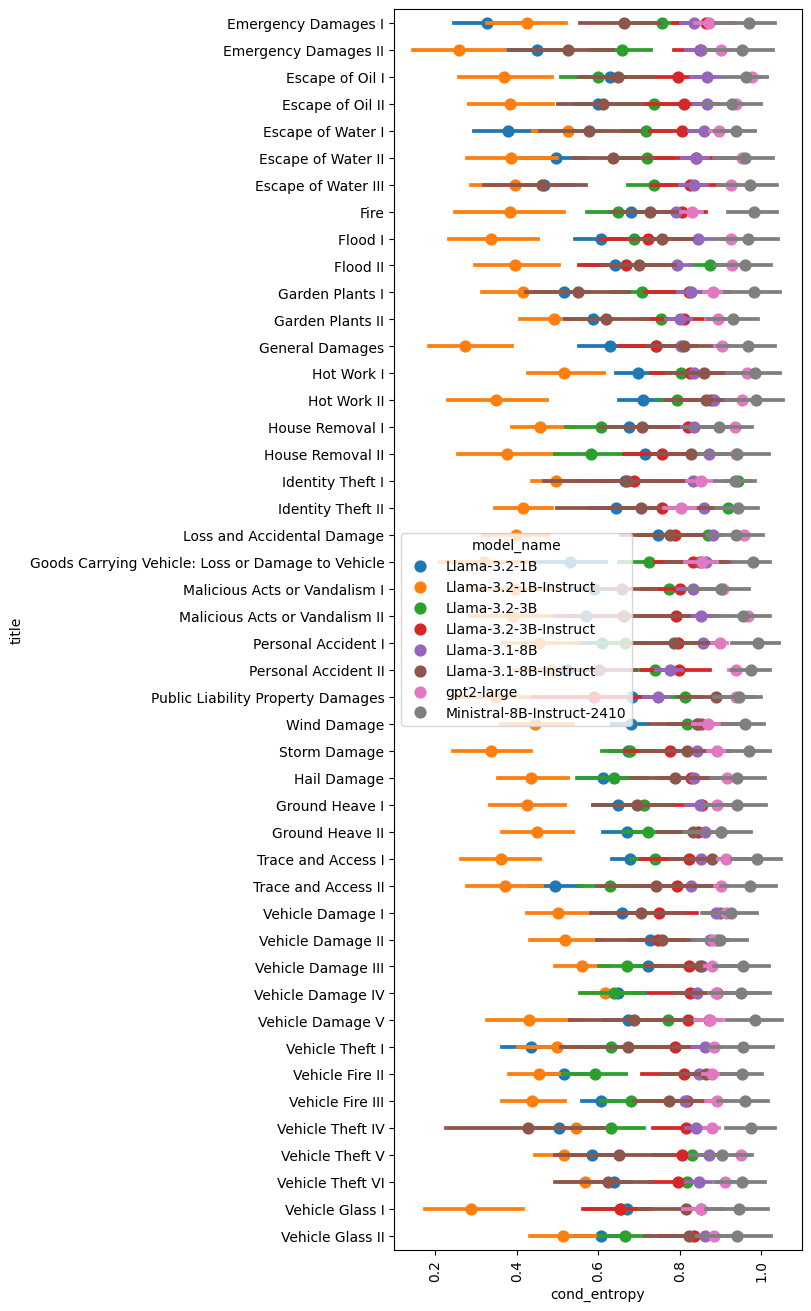

In [35]:
fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
plt.xticks(rotation=90)
# plt.set_ylim((0, 138))
point_plot = sns.pointplot(
    data = relative_measures,
    x='cond_entropy',
    y='title',
    hue='model_name',
    linestyle="None",
    # dodge=.8 - .8 / 8
)

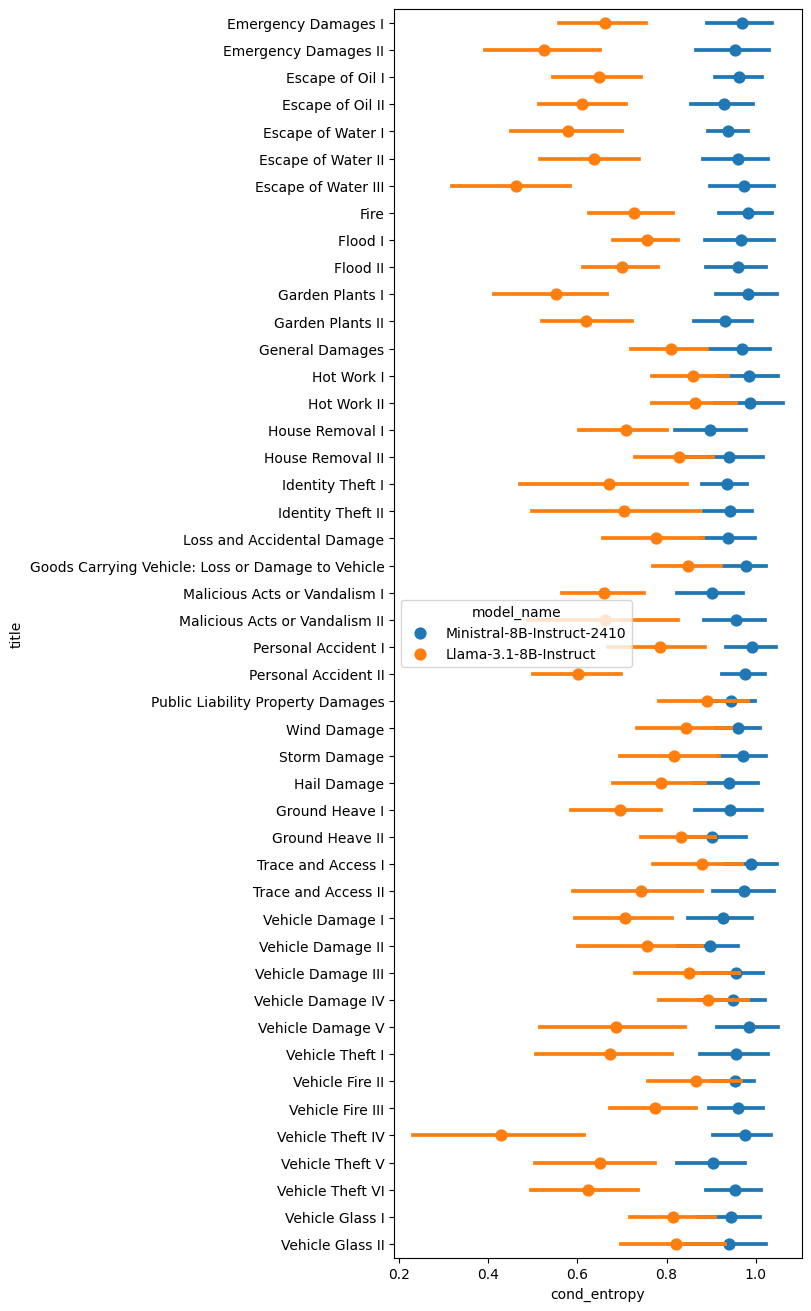

In [40]:
selected_models = ["Ministral-8B-Instruct-2410", "Llama-3.1-8B-Instruct"]
selected_df = relative_measures[relative_measures["model_name"].isin(selected_models)]

fig, ax = plt.subplots(1,1, figsize=(8,13), layout='constrained')
point_plot = sns.pointplot(
    data = selected_df,
    x='cond_entropy',
    y='title',
    hue='model_name',
    hue_order=selected_models,
    linestyle="None",
)

# Item wise Majority Votes

In [18]:
reversal_sums = relative_measures.groupby(['model_name', 'prompt_type'], as_index=False, sort=False).agg({"more_than_reversal": "sum"})
reversal_sums.groupby('model_name', as_index=False, sort=False).agg({"more_than_reversal": 'sum'})

,model_name,more_than_reversal
0,Llama-3.2-1B,460.0
1,Llama-3.2-1B-Instruct,17.0
2,Llama-3.2-3B,160.0
3,Llama-3.2-3B-Instruct,838.0
4,Llama-3.1-8B,944.0
5,Llama-3.1-8B-Instruct,199.0
6,gpt2-large,350.0
7,Ministral-8B-Instruct-2410,557.0


In [20]:
relative_measures.groupby(['model_name'], as_index=False, sort=False).agg({"js_dist": "mean"})

,model_name,js_dist
0,Llama-3.2-1B,0.172040
1,Llama-3.2-1B-Instruct,0.265191
2,Llama-3.2-3B,0.162331
3,Llama-3.2-3B-Instruct,0.210090
4,Llama-3.1-8B,0.082755
5,Llama-3.1-8B-Instruct,0.178282
6,gpt2-large,0.116326
7,Ministral-8B-Instruct-2410,0.112265


In [ ]:
reversal_sums.groupby('prompt_type', as_index=False, sort=False).agg({"more_than_reversal": 'sum'})

In [ ]:
(reversal_sums.pivot(index="model_name", columns="prompt_type").round(2))

In [ ]:
all_distances = pd.concat([all_distances, reversal_df]).reset_index()

NameError: name 'all_distances' is not defined

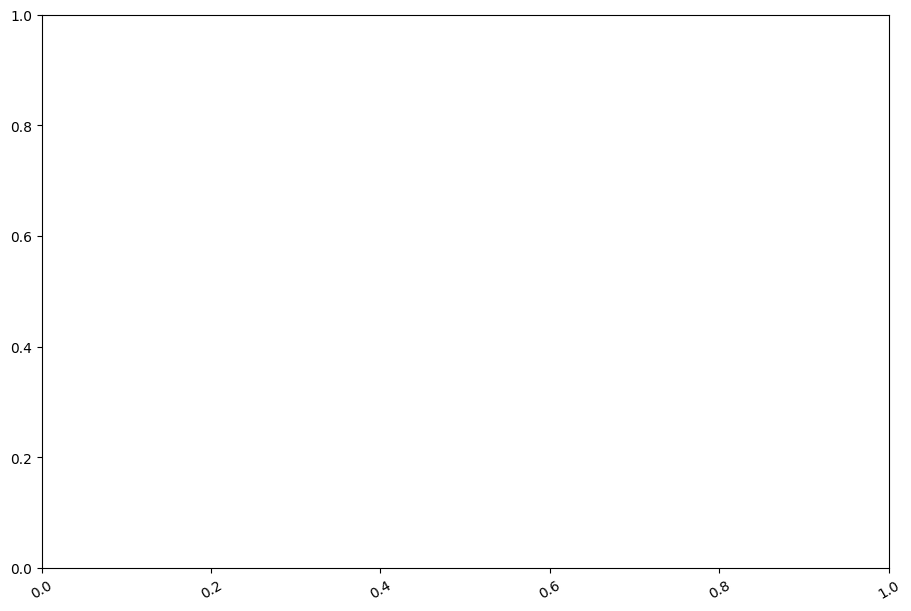

In [21]:
fig, ax = plt.subplots(1,1, figsize=(9,6), layout='constrained')
plt.xticks(rotation=30)
dist_plot_for_models = sns.barplot(
    data=all_distances, x='prompt_type', y ='js_dist', hue='model_name')
fig = dist_plot_for_models.get_figure()

In [ ]:
# all_distances.groupby(['model_name', 'prompt_type'], as_index=False, sort=False).agg(

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(9,6), layout='constrained')
plt.xticks(rotation=30)
dist_plot_for_models = sns.barplot(
    data=all_distances, x='prompt_type', y ='js_dist', hue='prompt_type')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(9,6), layout='constrained')
plt.xticks(rotation=30)
sns.pointplot(
    x = 'model_name', 
    y = 'js_dist',
    hue='prompt_type',
    data=all_distances,
    linestyle="None",
    ax = ax
)

In [ ]:
# all_distances.groupby('model_name

In [ ]:
dist_for_models = all_distances.groupby('model_name', as_index=False, sort=False).agg(
    {"js_dist" : ["mean"]}
)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(9,6), layout='constrained')
plt.xticks(rotation=30)
sns.barplot(data=dist_for_models, x='model_name', y=('js_dist', 'mean'), hue='model_name')

In [ ]:
control_prob_diff = control_df["Aff_prob"] - control_df["UnAff_prob"]
combined_prob_df = combined_df["Aff_prob"] - combined_df["UnAff_prob"]
control_prob_diff.mean(), combined_prob_df.mean()

In [ ]:
dist_for_item = all_distances.groupby(['title'], as_index=False, sort=False).agg(
    {
        "js_dist" : ["mean"]
    }
)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=30)
sns.barplot(y=('js_dist', 'mean'),  x= 'title', hue='title', data=dist_for_item, ax=ax)

In [ ]:
dist_for_items_by_versions = all_distances.groupby(['title', 'version'], as_index=False, sort=False).agg(
    {
        "js_dist" : "mean"
    }
)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=30)
ax.set_ylim((0.1, 0.26))
sns.barplot(y=('js_dist', 'mean'), x = 'title', hue='version', data=dist_for_items_by_versions, ax=ax)

In [ ]:
distances_by_version = all_distances.groupby(['version'], as_index=False, sort=False).agg(
    {'js_dist': 'mean'}    
)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=30)
ax.set_ylim((0.1, 0.26))
sns.barplot(y='js_dist', x = 'version', hue='version', data=all_distances, ax=ax)

In [ ]:
distances_by_models_for_version = all_distances.groupby(['version', 'model_name'], as_index=False, sort=False).agg(
    {'js_dist': 'mean'}    
)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=30)
# ax.set_ylim((0, ))
sns.barplot(y='js_dist', x = 'version', hue='model_name', data=distances_by_models_for_version, ax=ax)

# Entropy of the output dist

In [ ]:
combined_df.sample()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=30)
sns.barplot(x='prompt_type', y='entropy', hue='model_name', data=combined_df)

In [ ]:
res = combined_df.groupby(['prompt_type', 'model_name'], as_index=False, sort=False).agg(
    {
        "Aff_prob" : sp.stats.entropy,
        "UnAff_prob" : sp.stats.entropy,
        "Other_prob" : sp.stats.entropy
    }
)
res.columns = list(map(''.join, res.columns.values))
res = res.melt(id_vars=["prompt_type", "model_name"])\
    .groupby(['prompt_type', 'model_name', 'variable'], as_index=False, sort=False)\
    .agg({'value': 'mean'})
res

plt.xticks(rotation=30)
sns.barplot(data=res, x='prompt_type', y='value', hue='variable')

In [ ]:
combined_df.groupby(['prompt_type', 'model_name'], as_index=False, sort=False).agg(
    {
        "Aff_prob" : 'mean',
        "UnAff_prob" : 'mean',
        "Other_prob" : 'mean',
    }
)

In [ ]:
# # Normalized probability between two choices
# def normalize_probs(x, y):
#     total = x + y 
#     return x/total, y/total
# choice_total_probs = combined_df["Aff_prob"] + combined_df["UnAff_prob"]
# combined_df["Aff_prob"] = combined_df["Aff_prob"]/choice_total_probs
# combined_df["UnAff_prob"] = combined_df["UnAff_prob"]/choice_total_probs

In [ ]:
combined_df["entropy"] = combined_df[["Aff_prob", "UnAff_prob"]].apply(lambda x: sp.stats.entropy(x), axis=1)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=30)
sns.pointplot(x='prompt_type', y='entropy', hue='model_name', data=combined_df, linestyle="None")

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,6), layout='constrained')
plt.xticks(rotation=30)
sns.barplot(x='title', y='entropy', hue='version', data=combined_df)

# JSD Distance to reversal 

# Counts of Covered and Not Covered Answer - change in that